In [2]:
import os
import numpy as np
import scipy.signal
from scipy import stats
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import csv
import neurokit as nk

In [3]:
def OpenProj():
    pass # currently unavailable 
    #path = str(input("The path of project:"))
    #projnames = str(input("Project names (separate by ;):"))
    #projects = projnames.split(";")
    #os.chdir(path)
    #for project in projects:
    #open(project,'r','utf-8')

#Start a new project:
def NewProj():    
    ExpCon = str(input("Experimental Conditions (hypoxia or hypercapnia): "))
    if ExpCon == 'hypoxia': ExpCon = False
    elif ExpCon == 'hypercapnia': ExpCon = True
    else: print("Error[1]: Please define experimental conditions!")
    Treatment = input("CNO? (y/n): ")
    if Treatment == "y": 
        Dose = input("Dose (mg/kg): ") 
        Treatment = True
    elif Treatment == "n": Treatment = False
    else: print("Error[2]: Please define treatment!")
    GenoGroups = str(input("List all the genotypes in this project (separate by ;): "))
    GenoGroups = GenoGroups.split(";")
    return ExpCon, Treatment, GenoGroups, Dose

#input experiment data
def LoadFiles():    
    path = str(input("The path of file:"))
    filenames = str(input("File (MUIDs) names (separate by ;):"))
    files = filenames.split(";")
    return path, files

In [4]:
def ExpInfo(files,path):
    newpath = path+'/ExpInfo/'
    try: os.makedirs(newpath)
    except: pass
    os.chdir(newpath)
    #Experimental info input 
    #Eventually will get directly from experiment input
    Con = 0
    Exp = 0
    FlowRate = 0.19811 #float(input("Flow Rate (SLPH): ")), preset
    CalVolume = 0.02 #float(input("Calibration Volume (mL): ")), preset
    file2 = []

    for file in files:
        MUID = file
        print(MUID)
        Sex = str(input("Sex (m/f): "))
        Genotype = str(input("Genotype: "))
        Group = str(input("Group (Exp or Con): "))
        if Group == "Exp": Exp = Exp + 1
        elif Group == "Con": Con = Con +1        
        BodyWeight = float(input("Body Weight (g):"))
        TempBeginning = float(input("Beginning Temperature (C): "))
        try: TempMiddle = float(input("Middle Temperature(C): "))
        except: TempMiddle = input("Middle Temperature(C): ")
        TempEnd = float(input("End Temperature (C): "))
        try: TempPost30 = float(input("Post 30 min Temperature (C): "))
        except: 
            TempPost30 = input("Post 30 min Temperature (C): ")
            print("Warning: no Post 30 min Temperature input!")
        try: TempAverage1 = (TempBeginning+TempMiddle)/2
        except: TempAverage1 = (TempBeginning+TempEnd)/2
        try: TempAverage2 = (TempMiddle+TempEnd)/2
        except: TempAverage2 = TempAverage1
        TempRoom = (float(input("Room Temperature(F): "))-32)*5/9 #Celcius 
        BarometricPressure = float(input("Barometric Pressure (inHg): "))*25.4 #mmHg                              
        MouseWVPressure1 = 1.142 + (0.8017*TempAverage1) - (0.012*TempAverage1**2) + (0.0006468*TempAverage1**3)
        MouseWVPressure2 = 1.142 + (0.8017*TempAverage2) - (0.012*TempAverage2**2) + (0.0006468*TempAverage2**3)
        try: MouseWVPressureCNORA = 1.142 + (0.8017*TempMiddle) - (0.012*TempMiddle**2) + (0.0006468*TempMiddle**3);
        except: MouseWVPressureCNORA = 'NA'                             
        ExperimentDate = str(input("Experiment Date (mm/dd/yy): "))
        Emonth, Eday, Eyear = map(int, ExperimentDate.split('/'))  
        ExperimentDate = datetime.date(Eyear, Emonth, Eday)
        BirthDate = str(input("Birth Date (mm/dd/yy): "))
        Bmonth, Bday, Byear = map(int, BirthDate.split('/'))                         
        BirthDate = datetime.date(Byear, Bmonth, Bday)                   
        Age = ExperimentDate - BirthDate
        Age = Age.days
        filename_new = file+".csv"
        file_new =open(filename_new,'w')
        #writing information to MUID specific data file for future use
        writer = csv.writer(file_new, lineterminator='\n')
        writer.writerows([["MUID",MUID],
                         ["Sex",Sex],
                         ["Genotype",Genotype],
                         ["Group",Group],
                         ["Body Weight (g)",str(BodyWeight)],
                         ["Beginning Temperature",str(TempBeginning)],
                         ["Middle Temperature",str(TempMiddle)],
                         ["End Temperature",str(TempEnd)],
                         ["Post 30min Temperature",str(TempPost30)],
                         ["TempAverage1 (C)",str(TempAverage1)],
                         ["TempAverage2 (C)",str(TempAverage2)],
                         ["MouseWVPressureCNORA (mmHg)",str(MouseWVPressureCNORA)],
                         ["MouseWVPressure1 (mmHg)",str(MouseWVPressure1)],
                         ["MouseWVPressure2 (mmHg)",str(MouseWVPressure2)],
                         ["TempRoom (C)",str(TempRoom)],
                         ["BarometricPressure (mmHg)",str(BarometricPressure)],
                         ["Age (days)",str(Age)],
                         ["Cal Volume",str(CalVolume)],
                         ['Flow Rate',str(FlowRate)]])
        file_new.close()
        #Statistic analysis?
        
        #if min(Con,Exp)>=6:
        #    StatAna = True
        #    print("Statistic analysis is on")
        #else:
        #    Stat = str(input("Do you want perform statistic analysis? (y/n)"))
        #    if Stat == 'y': 
        #        StatAna = True
        #        print("Warning: Your sample size is small!")
        #    else: StatAna = False  
        StatAna = False # StatAna currently unavailable
    os.chdir(path)
    return  Stat, Con, Exp

In [5]:
#read datafiles
#bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
#Data collecting
#convert signal arrays to useful information (first data processing)
def DataColl(signal,file):
    comment = file+'_comment.txt'
    cmtfile = pd.read_csv(comment,delimiter = "\t",names=['1','2','3','4','5','6','7','8','9','10'],dtype=str)
    cmtfile = np.array(cmtfile)
    cmtfile = np.transpose(cmtfile)
    cmt_time = cmtfile[0]
    cmt = cmtfile[-1]
    for i in range(len(cmt_time)):
        s = str(cmt_time[i]).split(':')
        cmt_time[i] = int((float(s[0])*60+float(s[1]))*60+float(s[2]))

    #Data
    # 1. AvgFreq - Breathing Frequency (Rate)
    # 2. AvgHeight - Average height of peak
    # 3. O2Mean - Oxygen Mean
    # 4. CO2Mean - CO2 mean
    # 5 TempMean - Temperature mean
    # 6. CmtText - Comment Text
    Data = pd.DataFrame(columns=["AvgFreq","AvgHeight","O2Mean","CO2Mean","TempMean","CmtText"],index= cmt)
    for cmt_ind in range(len(cmt)):
        if cmt[cmt_ind] in ['Cal 20 Room Air','Cal 20 10% O2','Cal 20 5% CO2',
                        'Room Air','5% CO2','Room Air 2','10% O2',
                        'Pre-CNO Room Air','Pre-CNO 5% CO2',
                        'Post-CNO Room Air','Post-CNO 5% CO2','Post-CNO 10% O2']:
            if cmt[cmt_ind] in ['Cal 20 Room Air','Cal 20 10% O2','Cal 20 5% CO2']: 
                tcut_begin = cmt_time[cmt_ind]*1000
                tcut_end = tcut_begin+30*1000
                length = tcut_end - tcut_begin
                data_set = np.zeros((5,length))
                for k in range(5):
                    data_set[k] = signal[k][tcut_begin:tcut_end]
            else:
                if cmt[cmt_ind] in ['Pre-CNO Room Air','Room Air']: 
                    tcut_begin = max((cmt_time[cmt_ind+1]-40*60)*1000,cmt_time[cmt_ind])
                    tcut_end = (cmt_time[cmt_ind+1]-20*60)*1000
                elif cmt[cmt_ind] in ['Pre-CNO 5% CO2','5% CO2','10% O2','Room Air 2',
                                      'Post-CNO Room Air','Post-CNO 5% CO2','Post-CNO 10% O2']:
                    tcut_begin = (cmt_time[cmt_ind+1]-5*60)*1000
                    tcut_end = cmt_time[cmt_ind+1]*1000
                length = tcut_end - tcut_begin
                data_set = np.zeros((5,length))
                for k in range(5):
                    data_set[k] = signal[k][tcut_begin:tcut_end]
                
                data_set[1] = scipy.signal.detrend(data_set[1],type='linear') # baseline correction 
                data_set[1] = butter_bandpass_filter(data_set[1], 0.5, 8, 1000, order=3)#bandpass filter
                data_set[1] = scipy.signal.wiener(data_set[1])
            res_info = nk.rsp_process(data_set[1],sampling_rate= 100)
            exp_ind = res_info['RSP']['Expiration_Onsets']
            ins_ind = res_info['RSP']['Cycles_Onsets']
            cycles = res_info['RSP']['Cycles_Length']

            t1 = data_set[0][[min(exp_ind[0],ins_ind[0])]]
            t2 = data_set[0][max(exp_ind[-1],ins_ind[-1])]
            cyc = len(cycles)
            freq = cyc/(t2-t1)
            Data.iloc[[cmt_ind],[0]] = freq
            Data.iloc[[cmt_ind],[1]] = np.mean(data_set[1][exp_ind][0:cyc-1]-data_set[1][ins_ind][0:cyc-1])
            Data.iloc[[cmt_ind],[2]] = np.mean(data_set[2])
            Data.iloc[[cmt_ind],[3]] = np.mean(data_set[3])
            Data.iloc[[cmt_ind],[4]] = np.mean(data_set[4])
            Data.iloc[[cmt_ind],[5]] = cmt[cmt_ind]
            try: Data.drop(['Post-CNO Room Air 2'])
            except: pass
            try: Data.drop(['Pre-CNO Room Air 2'])
            except: pass
    data = file +'_data.csv'
    Data.to_csv(data,encoding='utf-8')  
     
    
#data acquisition from list of files/experiments
def DAQ(files,path):
    os.chdir(path)
    for file in files:
        signal = pd.read_csv(file+'.txt',delimiter = "\t",names=['t','breath','O2','CO2','T'])
        signal = signal.as_matrix()
        signal = np.transpose(signal)
        #singal
        #1. time
        #2. pressure/breathing pattern
        #3. O2
        #4. CO2
        #5. Temp
        DataColl(signal,file)
        print('%%%%%% '+file+' done%%%%%%')
 

In [25]:
#Data analysis

#different collecting methods based on assays

# for CNO treated hypercapnia assay    
def CNO_hyper(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
              TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2):
    for i in range(4):
        Results.iloc[[i],[0]] = Calibration[i+2][0]*60
        k = np.mod(i,2) 
        VTNum = (Calibration[i+2][1]/Calibration[k][1])*CalVolume*(TempAverage1+273.15)\
        *(BarometricPressure-Calibration[i+2][5])
        VTDenom = ((TempAverage1+273.15)* (BarometricPressure - Calibration[i+2][5])) \
        - ((Calibration[i+2][4]+273.15)*(BarometricPressure-MouseWVPressure1))
        Results.iloc[[i],[1]] = VTNum/VTDenom       
        Results.iloc[[i],[4]] = (((FlowRate*1000)*(Calibration[k][2]/100)) \
                                 - ((FlowRate*1000)*(Calibration[i+2][2]/100))) / BodyWeight
        Results.iloc[[i],[5]] = (((FlowRate*1000)*(Calibration[i+2][3]/100)) \
                                 - ((FlowRate*1000)*(Calibration[k][3]/100))) / BodyWeight   
        Results.iloc[[i],[2]] = Results.iloc[[i],[1]].values / BodyWeight
        Results.iloc[[i],[3]] = Results.iloc[[i],[0]].values*Results.iloc[[i],[2]].values
        Results.iloc[[i],[6]] = Results.iloc[[i],[3]].values / Results.iloc[[i],[4]].values
    return Results
# for CNO treated hypoxia assay   

def CNO_hypo(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
             TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2):
    for i in range(3):
        Results.iloc[[i],[0]] = Calibration[i+2][0]*60
        if i <2: k = 0
        else: k = 1
        VTNum = (Calibration[i+2][1]/Calibration[k][1])*CalVolume*(TempAverage1+273.15)\
        *(BarometricPressure-Calibration[i+2][5])
        VTDenom = ((TempAverage1+273.15)* (BarometricPressure - Calibration[i+2][5])) \
        - ((Calibration[i+2][4]+273.15)*(BarometricPressure-MouseWVPressure1))
        Results.iloc[[i],[1]] = VTNum/VTDenom       
        Results.iloc[[i],[4]] = (((FlowRate*1000)*(Calibration[k][2]/100)) \
                                 - ((FlowRate*1000)*(Calibration[i+2][2]/100))) / BodyWeight
        Results.iloc[[i],[5]] = (((FlowRate*1000)*(Calibration[i+2][3]/100)) \
                                 - ((FlowRate*1000)*(Calibration[k][3]/100))) / BodyWeight       
        Results.iloc[[i],[2]] = Results.iloc[[i],[1]].values / BodyWeight
        Results.iloc[[i],[3]] = Results.iloc[[i],[0]].values*Results.iloc[[i],[2]].values
        Results.iloc[[i],[6]] = Results.iloc[[i],[3]].values / Results.iloc[[i],[4]].values
    return Results

# for non CNO treated assays        
def nonCNO(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
           TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2):
    for i in range(3):
        Results.iloc[[i],[0]] = Calibration[i+2][0]*60
        k = np.mod(i,2) 
        VTNum = (Calibration[i+2][1]/Calibration[k][1])*CalVolume*(TempAverage1+273.15)\
        *(BarometricPressure-Calibration[i+2][5])
        VTDenom = ((TempAverage1+273.15)* (BarometricPressure - Calibration[i+2][5])) \
        - ((Calibration[i+2][4]+273.15)*(BarometricPressure-MouseWVPressure1))
        Results.iloc[[i],[1]] = VTNum/VTDenom       
        Results.iloc[[i],[4]] = (((FlowRate*1000)*(Calibration[k][2]/100)) \
                                 - ((FlowRate*1000)*(Calibration[i+2][2]/100))) / BodyWeight
        Results.iloc[[i],[5]] = (((FlowRate*1000)*(Calibration[i+2][3]/100)) \
                                 - ((FlowRate*1000)*(Calibration[k][3]/100))) / BodyWeight       
        Results.iloc[[i],[2]] = Results.iloc[[i],[1]].values / BodyWeight
        Results.iloc[[i],[3]] = Results.iloc[[i],[0]].values*Results.iloc[[i],[2]].values
        Results.iloc[[i],[6]] = Results.iloc[[i],[3]].values / Results.iloc[[i],[4]].values
    return Results

#convert information from each data file to respiratory parameters (second data processing)
def DataAna(path,files,Treatment,ExperimentCondition,GenoGroups,findex,summary,temp):
    #import data
    os.chdir(path)
    data = pd.read_csv(files[findex]+'_data.csv',index_col = 0)
    data = data.drop(['Post-CNO Room Air 2'])
    #import constant/experimental information
    os.chdir(path+'/ExpInfo')
    constant = pd.read_csv(files[findex]+'.csv', index_col = 0,names = ['parameter','value'])
    CmtTextChoices = np.array(data["CmtText"])
    DataSet = data[['AvgFreq','AvgHeight','O2Mean','CO2Mean','TempMean']]
    #Calibration
    #Conditions from Comments
    # 6 Parameters (columns)
    # 1. Frequency
    # 2. Volume
    # 3. O2 value
    # 4. CO2 value
    # 5. Temperature of chamber
    # 6. Presure of water vapour of chamber
    Calibration= pd.DataFrame(columns=["frequency","volume","O2","CO2","Temperature",
                                       "Presure of water vapour of chamber"], index= CmtTextChoices) 
    #Results
    #Conditions from Comments
    # 7 parameters:
    # 1. Vf (breaths/min)
    # 2. VT (mL/breath)
    # 3. VT (mL/breath/g)
    # 4. VE (mL/min/g)
    # 5. VO2 (mL/min/g)
    # 6. VCO2 (mL/min/g)
    # 7. VE/VO2 
    
    Results = pd.DataFrame(columns=["Vf","VT","VTg","VE","VO2","VCO2","VE/VO2"], 
                           index= CmtTextChoices[2:])
    MUID = constant.loc['MUID'].values[0]
    Genotype = constant.loc['Genotype'].values[0]
    CalVolume = float(constant.loc['Cal Volume'].values[0])
    FlowRate = float(constant.loc['Flow Rate'].values[0])
    TempAverage1 = float(constant.loc['TempAverage1 (C)'].values[0])
    TempAverage2 = float(constant.loc['TempAverage2 (C)'].values[0])
    BarometricPressure = float(constant.loc['BarometricPressure (mmHg)'].values[0])
    BodyWeight = float(constant.loc['Body Weight (g)'].values[0])
    MouseWVPressure1 = float(constant.loc['MouseWVPressure1 (mmHg)'].values[0])
    MouseWVPressure2 = float(constant.loc['MouseWVPressure2 (mmHg)'].values[0])
    for cmt in CmtTextChoices:
        Calibration.loc[[cmt],["frequency"]] = DataSet.loc[[cmt],['AvgFreq']].values  
        Calibration.loc[[cmt],["volume"]] = DataSet.loc[[cmt],['AvgHeight']].values 
        Calibration.loc[[cmt],["O2"]] = DataSet.loc[[cmt],['O2Mean']].values *10
        Calibration.loc[[cmt],["CO2"]] = DataSet.loc[[cmt],['CO2Mean']].values 
        Calibration.loc[[cmt],["Temperature"]] = DataSet.loc[[cmt],['TempMean']].values *1000
        Calibration.loc[[cmt],["Presure of water vapour of chamber"]] = 1.142 + \
        (0.8017*Calibration.loc[[cmt],['Temperature']].values) - \
        (0.012*(Calibration.loc[[cmt],['Temperature']].values**2)) + \
        (0.0006468*(Calibration.loc[[cmt],['Temperature']].values**3))
    #Geting results
    x = GenoGroups.index(Genotype)
    temp[x][0][findex]=constant.loc['Beginning Temperature'].values[0]
    temp[x][1][findex]=constant.loc['Middle Temperature'].values[0]
    temp[x][2][findex]=constant.loc['End Temperature'].values[0]
    temp[x][3][findex]=constant.loc['Post 30min Temperature'].values[0]
    Calibration = np.array(Calibration)
    if Treatment:
        if ExperimentCondition: 
            Results = CNO_hyper(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
                                TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2)     
            summary[x][0:4][findex][:]=Results.iloc[[0]].values                 
        else: 
            Results = CNO_hypo(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
                               TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2)
            summary[x][0][findex][:]=Results.iloc[0].values
            summary[x][1][findex][:]=Results.iloc[1].values
            summary[x][4][findex][:]=Results.iloc[2].values
    else: 
        Results = nonCNO(Calibration,Results,CalVolume,FlowRate,BarometricPressure,BodyWeight,
                         TempAverage1,TempAverage2,MouseWVPressure1,MouseWVPressure2)
        if ExperimentCondition: 
            summary[x][5][findex][:]=Results.iloc[0].values
            summary[x][8][findex][:]=Results.iloc[1].values
            summary[x][6][findex][:]=Results.iloc[2].values          
        else: 
            summary[x][5][findex][:]=Results.iloc[0].values
            summary[x][7][findex][:]=Results.iloc[1].values
            summary[x][6][findex][:]=Results.iloc[2].values 
    newpath = path+'/MUID'
    try: os.mkdir(newpath)
    except: pass
    file_results = MUID+'.csv'
    os.chdir(newpath)
    Results.to_csv(file_results,encoding='utf-8')  
    return summary,temp

#Compile data
def CompData(CompiledData,CompiledTemp,summary,temp,files):  
    #summary_init = np.zeros((Groups,9,7,len(files)))
    #preCNO_RA, preCNO_CO2, postCNO_RA, postCNO_O2, postCNO_CO2, RA, RA2, O2, CO2
    for i in range(len(CompiledData)):
        CompiledData[i][0]= np.nanmean(summary[i],axis = 2)
        CompiledData[i][1]= stats.sem(summary[i],axis = 2,nan_policy='omit')
    for i in range(len(CompiledTemp)):
        CompiledTemp[i][0] = np.nanmean(temp[i], axis = 1)
        CompiledTemp[i][1] = stats.sem(temp[i], axis = 1,nan_policy='omit')
    return CompiledData,CompiledTemp

In [7]:
#ploting
def PlotRes(path, Treatment, ExpCon,Compiled,CompiledTemp,GenoGroup):
    newpath = path+'/figures'
    try: os.mkdir(newpath)
    except: pass
    os.chdir(newpath)
    Titles = ['Respiratory Rate','Tidal Volume','Tidal Volume (BW)',
              'Minute Ventilation','$V_{O2}$','$V_{CO2}$','$V_{E}/V_{O2}$','Temperature']
    filenames = ['Respiratory Rate','Tidal Volume','Tidal Volume (BW)',
              'Minute Ventilation','O2','CO2','VE_VO2','Temperature']
    yaxis = ['Rate (beats/min)','Volume (mL/breath)','Volume (mL/breath/g)',
             'Volume (mL/min/g)','Volume (mL/min/g)','Volume (mL/min/g)','$V_{E}/$V_{O2}','Temperature']
    #ploting CNO-treated hypercapnic assay
    if Treatment and ExpCon:
        xlabel = ['RA', '5% CO_2']
        x = ['1','2']
        for geno in GenoGroup:
            print(geno)
            for i in range(7):
                fig = plt.figure(i)
                k = GenoGroup.index(geno)
                y1 = [CompiledD[k][0][0][i],Compiled[k][0][2][i]]
                error1 = [Compiled[k][1][0][i],Compiled[k][1][2][i]]
                y2 = [Compiled[k][0][1][i],Compiled[k][0][3][i]]
                error2 = [Compiled[k][1][1][i],Compiled[k][1][3][i]]
                plt.errorbar(x, y1, yerr = error1, fmt='ko-',ecolor = 'k',capsize = 2)
                plt.errorbar(x, y2, yerr = error2, fmt='ko-',mfc = 'w', ecolor = 'k',capsize = 2)
                plt.legend = ['Pre-CNO','Post-CNO']
                plt.title = Titles[i]
                plt.xticks(np.arange(1,3),xlabel)
                fig.savefig(Title[i]+'.tif',transparent = True)
                plt.show()
    #ploting CNO-treated hypoxia assay           
    elif Treatment and not ExpCon:
        xlabel = ['Pre-CNO RA', 'Post-CNO RA', 'Post-CNO 10% $O_2$']
        x = ['1','2','3']
        for i in range(7):
            fig = plt.figure(i)
            if len(GenoGroup) == 2: 
                y1 = [Compiled[0][0][0][i],Compiled[0][0][1][i],Compiled[0][0][4][i]]
                error1 = [Compiled[0][1][0][i],CompiledData[0][1][1][i],Compiled[0][1][4][i]]
                plt.errorbar(x, y1, yerr = error1, fmt='ko-',ecolor = 'k',capsize = 2)
                y2 = [Compiled[1][0][0][i],CompiledData[1][0][1][i],Compiled[1][0][4][i]]
                error2 = [Compiled[1][1][0][i],Compiled[1][1][1][i],Compiled[1][1][4][i]]
                plt.errorbar(x, y2, yerr = error2, fmt='ko-',mfc = 'w', ecolor = 'k',capsize = 2)
            elif len(GenoGroup)>2:
                for geno in GenoGroups:
                    k = GenoGroup.index(geno)
                    y = [Compiled[k][0][0][i],Compiled[k][0][1][i],Compiled[k][0][4][i]]
                    error = [Compiled[k][1][0][i],Compiled[k][1][1][i],Compiled[k][1][4][i]]
                    plt.errorbar(x, y, yerr = error, fmt='o-',capsize = 2)
            plt.xticks(np.arange(1,4),xlabel)
            plt.legend(GenoGroup)
            plt.ylabel(yaxis[i])
            plt.title(Titles[i])
            fig.savefig(filenames[i]+'.tif',transparent = True)
            plt.show()
    #ploting non-treated hypercapnia and hypoxia assay 
    else:
        x = ['1','2','3']
        if ExpCon: 
            xlabel = ['RA','5%CO2','RA2']
            y = Compiled[:][0][5][i]+Compiled[:][0][8][i]+Compiled[:][0][6][i]
            error = Compiled[:][1][5][i]+Compiled[:][1][8][i]+Compiled[:][1][6][i]
        else: 
            xlabel = ['RA','10%CO2','RA2']
            y = Compiled[:][0][5][i]+Compiled[:][0][7][i]+Compiled[:][0][6][i]
            error = Compiled[:][1][5][i]+Compiled[:][1][7][i]+Compiled[:][1][6][i]
        for i in range(7):
            plt.figure(i)
            for geno in GenoGroup:
                k = GenoGroup.index(geno)
                plt.errorbar(x, y[k], yerr = error, fmt='o-',capsize = 2)
                plt.legend = GenoGroup
                plt.ylabel = y[i]
                plt.title = Titles[i]
                plt.xticks(np.arange(1,4),xlabel)
            fig.savefig(Title[i]+'.tif',transparent = True)
            plt.show()
    fig = plt.figure()
    x = ['1','2','3','4']
    CompiledTemp = np.ndarray.tolist(CompiledTemp)
    if len(GenoGroups)>2:    
        for i in range(len(GenoGroups)):
            plt.errorbar(x,CompiledTemp[i][0],yerr =CompiledTemp[i][1],fmt='o-',capsize = 2 )
    else:
        plt.errorbar(x,CompiledTemp[0][0],yerr =CompiledTemp[0][1],fmt='ko-', ecolor = 'k',capsize = 2 )
        plt.errorbar(x,CompiledTemp[1][0],yerr =CompiledTemp[1][1],fmt='ko-',mfc = 'w', ecolor = 'k',capsize = 2 )
        plt.legend(GenoGroups)
        plt.xticks(np.arange(1,5),['TempBeg','TempMid','TempEnd','Temp30'])
        plt.ylabel(yaxis[7])
        plt.title(Titles[7])
    fig.savefig(filenames[7]+'.tif',transparent = True)
    plt.show()  

#statistical analysis 
def StatAna(Treatment, ExpCon,Compiled,CompiledTemp):
    pass

#generate report
def Report(path, Stat,Treatment, ExpCon, Compiled,CompiledTemp,GenoGroup):
    if Stat: StatAna(Treatment, ExpCon,Compiled,CompiledTemp)
    else: pass
    PlotRes(path, Treatment, ExpCon,Compiled,CompiledTemp,GenoGroup)

In [23]:
def main():
    Res = input("Start a new project? (y/n): ")
    if Res == "n":
        OpenProj()    
    else: 
        ExpCon, Treatment, GenoGroups, Dose = NewProj()
        path, files = LoadFiles()
        os.chdir(path)
        Con = 0
        Exp = 0
        Stat = False
        Stat, Con, Exp = ExpInfo(files,path)
        DAQ(files,path)
        #preset arrays
        Groups = len(GenoGroups)
        #initiate summary
        summary_init = np.zeros((Groups,9,len(files),7))
        #preCNO_RA, preCNO_CO2, postCNO_RA, postCNO_O2, postCNO_CO2, RA, RA2, O2, CO2
        #initiate temp
        temp_init = np.zeros((Groups,4,len(files)))
        #run data
        for findex in range(len(files)):
            summary,temp = DataAna(path,files,Treatment,ExpCon,
                                   GenoGroups,findex,summary_init,temp_init)
        #initiate Compiled information 
        #Groups
          #1. Mean
          #2. SEM
            #1-9 preCNO_RA, preCNO_CO2, postCNO_RA, postCNO_O2, postCNO_CO2, RA, RA2, O2, CO2
        CompiledData_init = np.zeros((Groups,2,9,7))
        #Groups
          #1. Mean
          #2. SEM
            #1. Beginning Temp
            #2. Middle Temp
            #3. End Temp
            #4. Post 30 min Temp
        CompiledTemp_init = np.zeros((Groups,2,4))
        summary = summary.transpose((0,1,3,2))
        summary[summary==0]=np.nan
        temp[temp==0]=np.nan
        CompiledData, Com = CompData(CompiledData_init,CompiledTemp_init,summary,temp,files)
        Report(path, Stat,Treatment,ExpCon,CompiledData,CompiledTemp,GenoGroups)    
        print('No. of Control: ',Con,'\nNo. of Experimental: ', Exp)

Start a new project? (y/n): y


/Users/huananshi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: Mean of empty slice


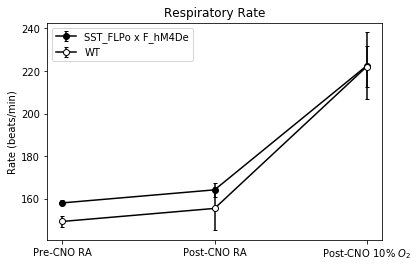

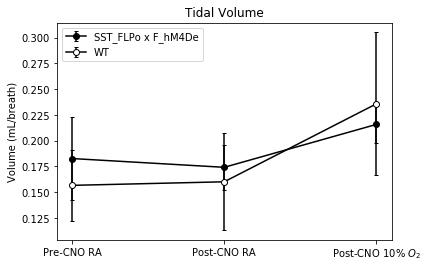

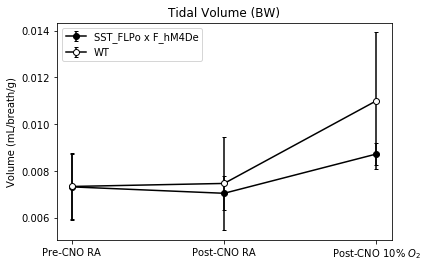

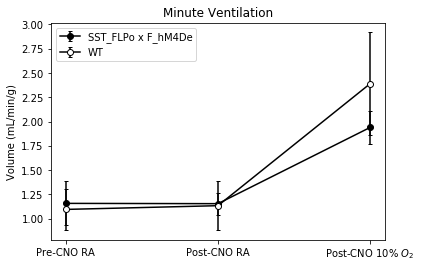

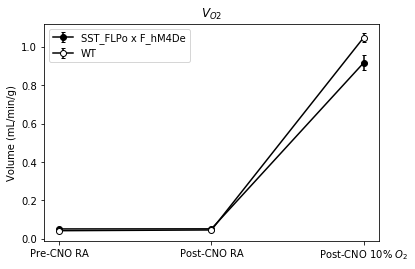

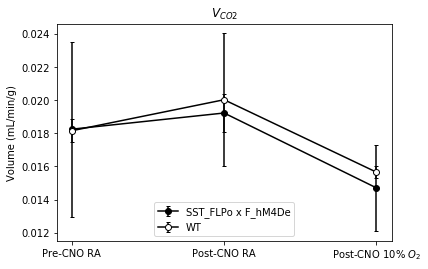

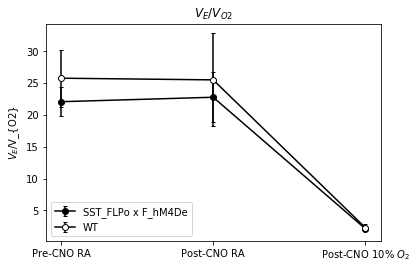

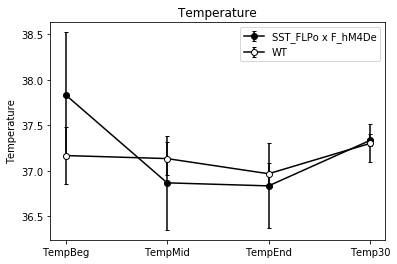

In [108]:
main()